# PitchShiftNN Training
This is the notebook used to train the Vocal Pitch Modulator.

## Global variables/Imports
Run these cells before running either of the following sections.

In [1]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport PitchShiftNN
from PitchShiftNN import *

In [2]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

## Data Generation
The methodology is explained in `Data Processing for Training PitchShiftNN.ipynb`.

In [3]:
# e.g. data_list[vowel_to_label["dog"]][5][1]
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                                     n_pitches, n_vowels, n_people)

# e.g. flat_data_ref_list[flat_ref_idx(3, 1, 2)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)

# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

In [4]:
data_label_pairs, data_label_pairs_dict = create_data_label_pairs(n_pitches)

all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
                              flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, plot=False, overlap=0.75) for waveform in all_wav_data ])

In [139]:
def create_training_dataset(shift_amt):
    """ 
    Creates X_train, X_val, Y_train, Y_val, list_of_test_idx for a single shift constant.

    Requires data_label_pairs_dict, all_wav_data, and all_spectrograms to be first created outside this method.

    Parameters: 
    shift_amt (int): -15 <= x <= 15

    Returns: 
    ndarray: X_train
    ndarray: Y_train
    ndarray: X_val
    ndarray: Y_val
    ndarray: list_of_test_idx
        each element is (flat idx of original, flat idx of original + shift_amt)
    """
    
    pairs = data_label_pairs_dict[shift_amt]

    # X_train_base, Y_train: (_,513), (_,513)
    # X_val_base, Y_val:     (_,513), (_,513)

    X_train_base = []; X_val_base = []; Y_train = []; Y_val = [];
    list_of_test_idx = []

    for vow_idx in range(n_vowels):
        for pit_idx in range(n_pitches):

            # If the pair is valid, then proceed.
            if [shift_amt, pit_idx, pit_idx + shift_amt] in pairs:

                # Choose the person for this pitch/vowel to be used as test data.
                test_pid = int(np.random.rand() * 3)

                for pid_idx in range(n_people):
                    wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                    wav_idx_shifted = flat_ref_idx(vow_idx, pit_idx + shift_amt, pid_idx)

                    if (pid_idx != test_pid):
                        X_train_base.extend(all_spectrograms[wav_idx].T)
                        Y_train.extend(all_spectrograms[wav_idx_shifted].T)
                    else:
                        X_val_base.extend(all_spectrograms[wav_idx].T)
                        Y_val.extend(all_spectrograms[wav_idx_shifted].T)
                        list_of_test_idx.append((wav_idx,wav_idx_shifted))

    X_train_base = np.array(X_train_base); Y_train = np.array(Y_train);
    X_val_base = np.array(X_val_base); Y_val = np.array(Y_val);
    list_of_test_idx = np.array(list_of_test_idx)
                    
    print(X_train_base.shape)
    print(Y_train.shape)
    print(X_val_base.shape)
    print(Y_val.shape)
    print(list_of_test_idx.shape)

    X_train_shifted = np.array([ simple_fft_pitch_shift(x, shift_amt) for x in X_train_base ])
    X_val_shifted = np.array([ simple_fft_pitch_shift(x, shift_amt) for x in X_val_base ])

    print(X_train_shifted.shape)
    print(X_val_shifted.shape)

    # X_train, X_val: (_,1026 = 513*2), (_,1026 = 513*2)

    X_train = np.hstack((X_train_base,X_train_shifted))
    X_val = np.hstack((X_val_base,X_val_shifted))

    print(X_train.shape)
    print(X_val.shape)

    X_train = np.absolute(X_train)
    X_val = np.absolute(X_val)
    Y_train = np.absolute(Y_train)
    Y_val = np.absolute(Y_val)
    
    return X_train, Y_train, X_val, Y_val, list_of_test_idx

In [193]:
X_train_prenorm, Y_train_prenorm, X_val_prenorm, Y_val_prenorm, list_of_test_idx = create_training_dataset(5)

(30360, 513)
(30360, 513)
(15180, 513)
(15180, 513)
(132, 2)
(30360, 513)
(15180, 513)
(30360, 1026)
(15180, 1026)


In [194]:
# Scale normalization
X_train, X_train_scale = normalize_rows(X_train_prenorm, NormMode.NONNEG_TO_ZERO_ONE)
Y_train, Y_train_scale = normalize_rows(Y_train_prenorm, NormMode.NONNEG_TO_ZERO_ONE)
X_val, X_val_scale = normalize_rows(X_val_prenorm, NormMode.NONNEG_TO_ZERO_ONE)
Y_val, Y_val_scale = normalize_rows(Y_val_prenorm, NormMode.NONNEG_TO_ZERO_ONE)

##################################################################
#                                                                #
#   How to recover the unnormalized data:                        #
#                                                                #
#   np.array([ x / y for x,y in zip(X_train,X_train_scale) ])    #
#                                                                #
##################################################################

# Convert into PyTorch tensor format

X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
X_train = X_train.float(); X_val = X_val.float()
Y_train = Y_train.float(); Y_val = Y_val.float()

### PitchShiftNN

Input: `(original window, manual pitch shifted window)`

Output: `(natural pitch shifted window)`

In [195]:
n_input = 1026; n_hid = 1026; n_output = 513;
n_epochs = 5000; lr = 0.2;

# Define model
model = PitchShiftNN(n_input = n_input, n_hid = n_hid, n_output = n_output)

# Define loss 
loss_fn = nn.L1Loss()

In [196]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

GPU Available


torch.Size([30360, 1026])


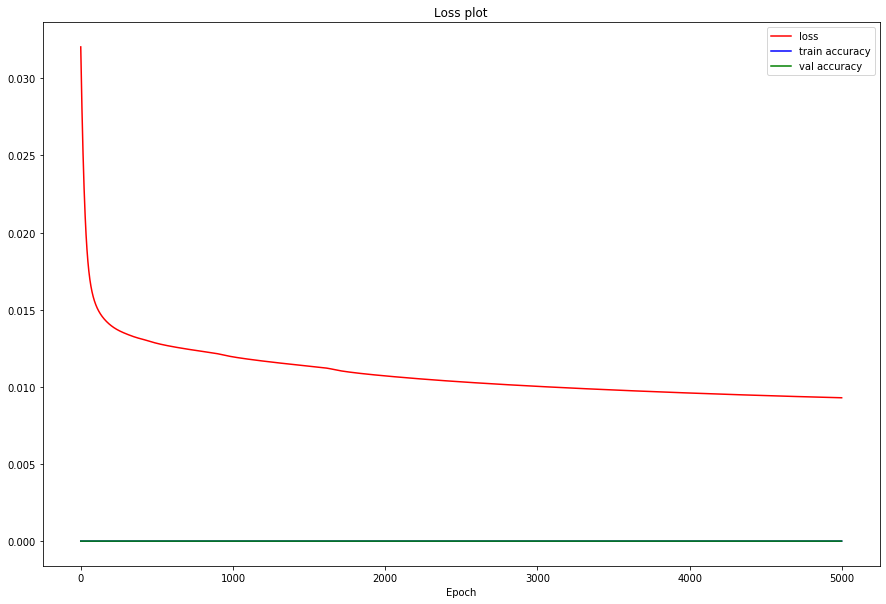

Training Loss before/after: 0.03203140199184418, 0.009289724752306938
Training accuracy before/after: 0, 0
Validation accuracy before/after: 0, 0
Final loss: 0.009289724752306938
Time taken: 591.1171576976776


In [197]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Move the network to GPU (if possible)
model.to(device)

# Define optimizer 
opt = optim.SGD(model.parameters(), lr=lr)
# opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                        loss_fn, epochs=n_epochs, print_graph=True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(loss, toc - tic))

Saving the model

In [198]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "PitchShiftNN_{}_{}_{}_{}_{}_{}.pt"
                          .format(lr, n_epochs, n_input, n_hid, n_output, loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Model's state_dict:
output.weight 	 torch.Size([513, 1026])
output.bias 	 torch.Size([513])
Model saved at model_data\PitchShiftNN_0.2_5000_1026_1026_513_0.009289724752306938.pt


In [199]:
def create_testing_dataset(input_idx, output_idx):
    """ 
    Creates X, Y given the input_idx, output_idx.

    Requires all_spectrograms to be first created outside this method.

    Parameters: 
    input_idx (int): the flat idx of the original sample
    output_idx (int): the flat idx of the sample shifted by shift_amt

    Returns: 
    ndarray: X
    ndarray: Y
    """
    # Get STFT output
    input_track_spec = all_spectrograms[input_idx].T
    output_track_spec = all_spectrograms[output_idx].T
    
    print(input_track_spec.shape)
    print(output_track_spec.shape)
    
    # Calculate shift amount based on input_idx and output_idx
    _,a,_ = nd_ref_idx(input_idx)
    _,b,_ = nd_ref_idx(output_idx)
    shift_amt = b-a
    
    # Generate manual pitch shift output
    input_track_spec_shifted = np.array([ simple_fft_pitch_shift(x, shift_amt) for x in input_track_spec ])
    
    # Generate stacked input
    X = np.hstack((input_track_spec, input_track_spec_shifted))
    
    # Squash information to magnitudes only
    X = np.absolute(X)
    Y = np.absolute(output_track_spec)
    
    return X, Y

In [206]:
input_idx = list_of_test_idx[0][0]
output_idx = list_of_test_idx[0][1]

# print(list_of_test_idx)
# input_idx = 0
# output_idx = 0

X, Y = create_testing_dataset(input_idx, output_idx)

# Data normalization
X, X_scale = normalize_rows(X, NormMode.NONNEG_TO_ZERO_ONE)
Y, Y_scale = normalize_rows(Y, NormMode.NONNEG_TO_ZERO_ONE)

print(np.amax(X), X_scale)
print(np.amax(Y), Y_scale)

# Create PyTorch tensor object from NumPy array
X = torch.Tensor(X)
X = X.float()

print(X)

(115, 513)
(115, 513)
1.0 [0.00754299 0.00743217 0.00726592 0.0071929  0.00698372 0.00704117
 0.00705172 0.00692018 0.00698659 0.00703836 0.00705429 0.00730207
 0.00741717 0.00751198 0.00795952 0.00816501 0.00851289 0.00920744
 0.00972849 0.01045407 0.01082024 0.0106974  0.01008917 0.00971795
 0.01041083 0.01085967 0.01079489 0.01128419 0.01172485 0.01138201
 0.01139421 0.01172761 0.011616   0.01151644 0.01145147 0.01141606
 0.01193808 0.01288102 0.01368989 0.01441416 0.01426466 0.01364144
 0.01330664 0.01283212 0.01221231 0.01121328 0.01016491 0.00928913
 0.00837334 0.00797461 0.00768985 0.00724771 0.00712468 0.0070959
 0.00723887 0.00789184 0.00851853 0.00897918 0.00896491 0.00826242
 0.00812242 0.00834991 0.00832929 0.00819443 0.00794151 0.00753723
 0.00741247 0.0074544  0.00757923 0.00799417 0.00838754 0.0086674
 0.00878082 0.0090897  0.00982889 0.0101036  0.01000021 0.00997451
 0.00971429 0.00892668 0.00845084 0.00826931 0.00815183 0.00814655
 0.00841096 0.00860481 0.00844274 0.00

Loading the saved model, and using the model for prediction (whole dataset) example

In [207]:
model = PitchShiftNN(n_input = n_input, n_hid = n_hid, n_output = n_output)
model.load_state_dict(torch.load(model_path))
model.eval()

PitchShiftNN(
  (output): Linear(in_features=1026, out_features=513, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [208]:
X = X.to(device)
model.to(device)

# Make prediction
Y_hat = model(X)

print(Y)
print(Y_hat)

# Create NumPy array from PyTorch tensor object, and undo normalization
Y_hat_np = Y_hat.cpu().detach().numpy()
Y_hat_renorm = np.array([ x / y for x,y in zip(Y_hat_np,Y_scale) ])
Y_renorm = np.array([ x / y for x,y in zip(Y,Y_scale) ])

print(np.amax(Y_renorm))
print(np.amax(Y_hat_renorm))

# Computes the total deviation across the entire input for an intuitive grasp on error (~1.5 means all 0's)
print(np.sum(np.absolute(Y_renorm - Y_hat_renorm)) / Y_renorm.size)

[[1.9670267e-01 2.2070403e-01 2.2797365e-01 ... 1.4031314e-03
  1.4517040e-03 1.4817051e-03]
 [7.9807863e-02 8.4611945e-02 1.2633522e-01 ... 6.2147708e-04
  5.8302155e-04 6.6453882e-04]
 [5.0375350e-03 2.9296228e-03 3.1741343e-02 ... 3.9773957e-05
  4.4637178e-05 4.6492194e-05]
 ...
 [8.2282536e-04 4.3274490e-03 4.0704452e-02 ... 4.7155190e-05
  6.5443870e-05 3.9019862e-05]
 [8.5512543e-04 6.5781707e-03 4.1011326e-02 ... 4.8990369e-05
  8.2417115e-05 4.5607900e-05]
 [3.8840853e-02 3.7415110e-02 6.1820738e-02 ... 7.6010285e-05
  8.4574334e-05 4.5893114e-05]]
tensor([[0.0000, 0.0000, 0.0059,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0276,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0482,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0474,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0507,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0272,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<TanhB

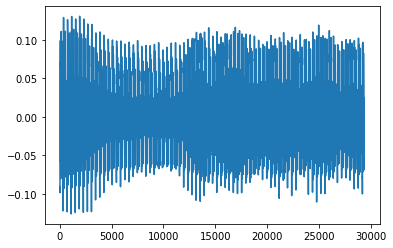

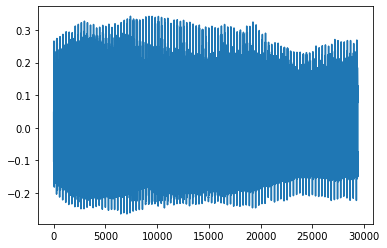

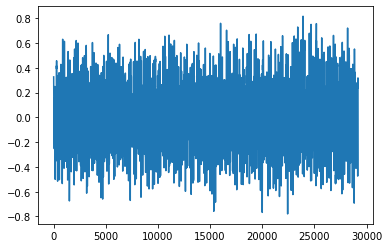

In [209]:
# The input track

waveform_original = all_wav_data[input_idx]
vowel_num,pitch_num,_ = nd_ref_idx(input_idx)
sio.wavfile.write('Input {} {}.wav'.format(label_to_vowel[vowel_num], noteidx_to_pitch[pitch_num]), 44100, waveform_original)

plt.figure()
plt.plot(waveform_original)

# The target track

waveform_target = all_wav_data[output_idx]
vowel_num,pitch_num,_ = nd_ref_idx(output_idx)
sio.wavfile.write('Target {} {}.wav'.format(label_to_vowel[vowel_num], noteidx_to_pitch[pitch_num]), 44100, waveform_target)

plt.figure()
plt.plot(waveform_target)

# The no-NN reconstruction of target track

gl_waveform_no_nn = librosa.griffinlim(np.transpose(Y_renorm), win_length=1024, hop_length=1024 // 4)
vowel_num,pitch_num,_ = nd_ref_idx(output_idx)
sio.wavfile.write('GL(Target) {} {}.wav'.format(label_to_vowel[vowel_num], noteidx_to_pitch[pitch_num]), 44100, gl_waveform_no_nn)

plt.figure()
plt.plot(gl_waveform)

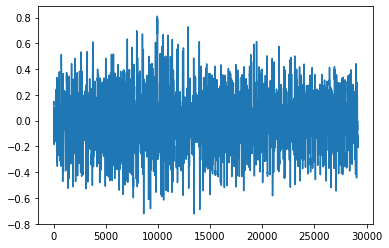

In [210]:
# The NN reconstruction of target track
gl_waveform = librosa.griffinlim(np.transpose(Y_hat_renorm), win_length=1024, hop_length=1024 // 4)
vowel_num,pitch_num,_ = nd_ref_idx(output_idx)
sio.wavfile.write('GL(Output) {} {}.wav'.format(label_to_vowel[vowel_num], noteidx_to_pitch[pitch_num]), 44100, gl_waveform)

plt.figure()
plt.plot(gl_waveform)

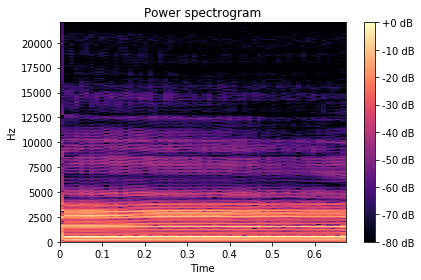

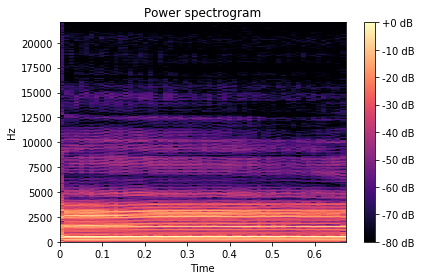

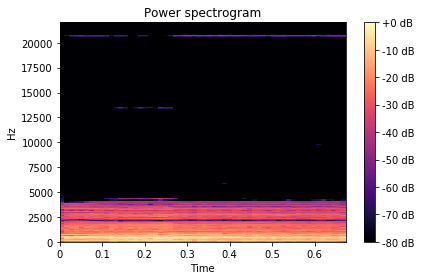

array([[ 6.03973448e-01+0.0000000e+00j,  3.08588803e-01+0.0000000e+00j,
        -3.88654023e-01+0.0000000e+00j, ...,
        -1.41009808e-01+0.0000000e+00j, -2.18691230e-01+0.0000000e+00j,
        -1.20297229e+00+0.0000000e+00j],
       [-6.49022281e-01+7.6718146e-16j, -6.94115758e-01+1.5686146e+00j,
        -8.11384737e-01+1.4229171e+00j, ...,
        -7.77137399e-01+9.9725771e-01j, -1.35022199e+00+1.0772580e+00j,
        -6.52333617e-01-1.5388344e-02j],
       [-1.49364603e+00+2.8514935e-16j,  1.07408738e+00-3.2861226e+00j,
         8.30701411e-01-4.3785486e+00j, ...,
         2.44811940e+00-4.7419043e+00j,  6.75257266e-01-3.8259897e+00j,
         2.21127439e+00+2.5317097e-02j],
       ...,
       [ 5.57429041e-04-5.0025506e-16j, -1.13285765e-07-1.7525055e-07j,
         1.49326198e-07+1.7199045e-07j, ...,
        -2.49480053e-07+2.0776358e-07j, -1.91524123e-07-4.1504583e-07j,
         3.58552695e-03-4.4141925e-05j],
       [-5.56482992e-04-2.4329497e-16j,  1.99407600e-06-1.3532967e-0

In [211]:
plt.figure()
stft(all_wav_data[output_idx])

plt.figure()
stft(gl_waveform_no_nn)

plt.figure()
stft(gl_waveform)